In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/teo/userdata/git_libraries/Yeominrak


In [2]:
from pathlib import Path
import music21
from music21 import converter, stream, note as m21_note 
from typing import List, Set, Dict, Tuple
import torch
from collections import defaultdict, Counter
import copy
import numpy as np

import yeominrak_processing
import model_zoo
from yeominrak_processing import AlignedScore, SamplingScore, pack_collate, ShiftedAlignedScore, TestScore
from model_zoo import Seq2seq, Converter, AttentionSeq2seq, QkvAttnSeq2seq, get_emb_total_size
import random as random
from loss import nll_loss
from trainer import Trainer
from decode import MidiDecoder
from torch.nn.utils.rnn import pack_sequence, PackedSequence, pad_packed_sequence, pack_padded_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from omegaconf import OmegaConf
from metric import make_dynamic_template, convert_note_to_sampling, get_similarity, get_correspondence
from constants import get_dynamic

In [27]:
# config = OmegaConf.load('yamls/baseline.yaml')
config = OmegaConf.load('yamls/sampling_roll.yaml')
config = get_emb_total_size(config)
device = 'cpu'
config.model.features.append('duration')

In [28]:
if 'sampling_rate' in config.data and 'samlping_rate' not in config.model:
  config.model.sampling_rate = config.data.sampling_rate

In [4]:
dataset_class = getattr(yeominrak_processing, config.dataset_class)
model_class = getattr(model_zoo, config.model_class)


train_dataset = dataset_class(is_valid= False, 
                              xml_path='0_edited.musicxml',
                              use_pitch_modification = config.data.use_pitch_modification, 
                              pitch_modification_ratio=config.data.modification_ratio,
                              min_meas=config.data.min_meas, 
                              max_meas=config.data.max_meas,
                              feature_types=config.model.features,
                              sampling_rate=2
                              )
val_dataset = dataset_class(is_valid= True, 
                            xml_path='0_edited.musicxml', 
                            use_pitch_modification=False, 
                            slice_measure_num=config.data.max_meas, 
                            min_meas=config.data.min_meas,
                            feature_types=config.model.features,
                            sampling_rate=2)

train_loader = DataLoader(train_dataset, batch_size=config.train.batch_size , shuffle=True, collate_fn=pack_collate)
valid_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, collate_fn=pack_collate, drop_last=True)



In [ ]:

device = 'cuda'
model = model_class(train_dataset.tokenizer, config.model).to(device)

model.is_condition_shifted = (config.dataset_class == "ShiftedAlignedScore")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
save_dir = Path('./debug/')
loss_fn = nll_loss
trainer = Trainer(model=model, optimizer=optimizer, 
                  loss_fn=loss_fn, train_loader=train_loader, 
                  valid_loader=valid_loader, device = device, save_log=False, save_dir=save_dir)


In [48]:
from model_zoo import QkvRollSeq2seq

model = QkvRollSeq2seq(train_dataset.tokenizer, config.model)
state = torch.load("outputs/2023-12-11/00-12-40/best_model.pt")
model.load_state_dict(state)

<All keys matched successfully>

In [56]:
from metric import convert_onset_to_sustain_token


decoder = MidiDecoder(train_dataset.tokenizer)
sample = val_dataset[1][0]

# def sequential_inference(model:Seq2seq, sample:torch.Tensor, decoder):
s = stream.Score(id='mainScore')

# output_part_idx = 1
for i in range(7):
  if model.is_condition_shifted:
    src, output, attention_map = model.shifted_inference(sample, i+1)
  else:
    src, output, attention_map = model.inference(sample, i+1)    
  if i == 0:
    merged_part = stream.Part() 
    src_midi = decoder(src)
    for element in src_midi:
      merged_part.append(element)
    s.insert(0, merged_part)
  output_midi = decoder(output)
  merged_part = stream.Part() 
  for element in output_midi:
    merged_part.append(element)
  s.insert(0, merged_part)

  if model.is_condition_shifted:
    pred, condition = [note[:3] for note in output], [note[3:] for note in output]
    initial_condition_token = []
    if 'offset' in model.tokenizer.key_types:
      initial_condition_token.append(0)
    if 'dynamic' in model.tokenizer.key_types:
      initial_condition_token.append('strong')
    if 'measure_idx' in model.tokenizer.key_types:
      initial_condition_token.append(0)
    if 'measure_changed' in model.tokenizer.key_types:
      initial_condition_token.append(1)

    output = [pred[0] + initial_condition_token] + [pr + con for pr, con in zip(pred[1:], condition[:-1])] + [[i+1] + ['end'] * (len(model.tokenizer.key_types)-1)]
    output = [[i+1] +  ['start'] * (len(model.tokenizer.key_types)-1)] + output
    sample = [model.tokenizer(note) for note in output]
  elif hasattr(model, 'sampling_rate'):
    converted_output = convert_note_to_sampling(output, model.dynamic_template_list, beat_sampling_num=model.sampling_rate)
    converted_output = convert_onset_to_sustain_token(converted_output)
    sample = [model.tokenizer(item) for item in converted_output]

  else:
    output = [[i+1] +  ['start'] * (len(model.tokenizer.key_types)-1)] + output + [[i+1] + ['end'] * (len(model.tokenizer.key_types)-1)]
    sample = [model.tokenizer(note) for note in output]

  sample = torch.Tensor(sample).long()

  return s
# sequential_inference(model, val_dataset[0][0], decoder)

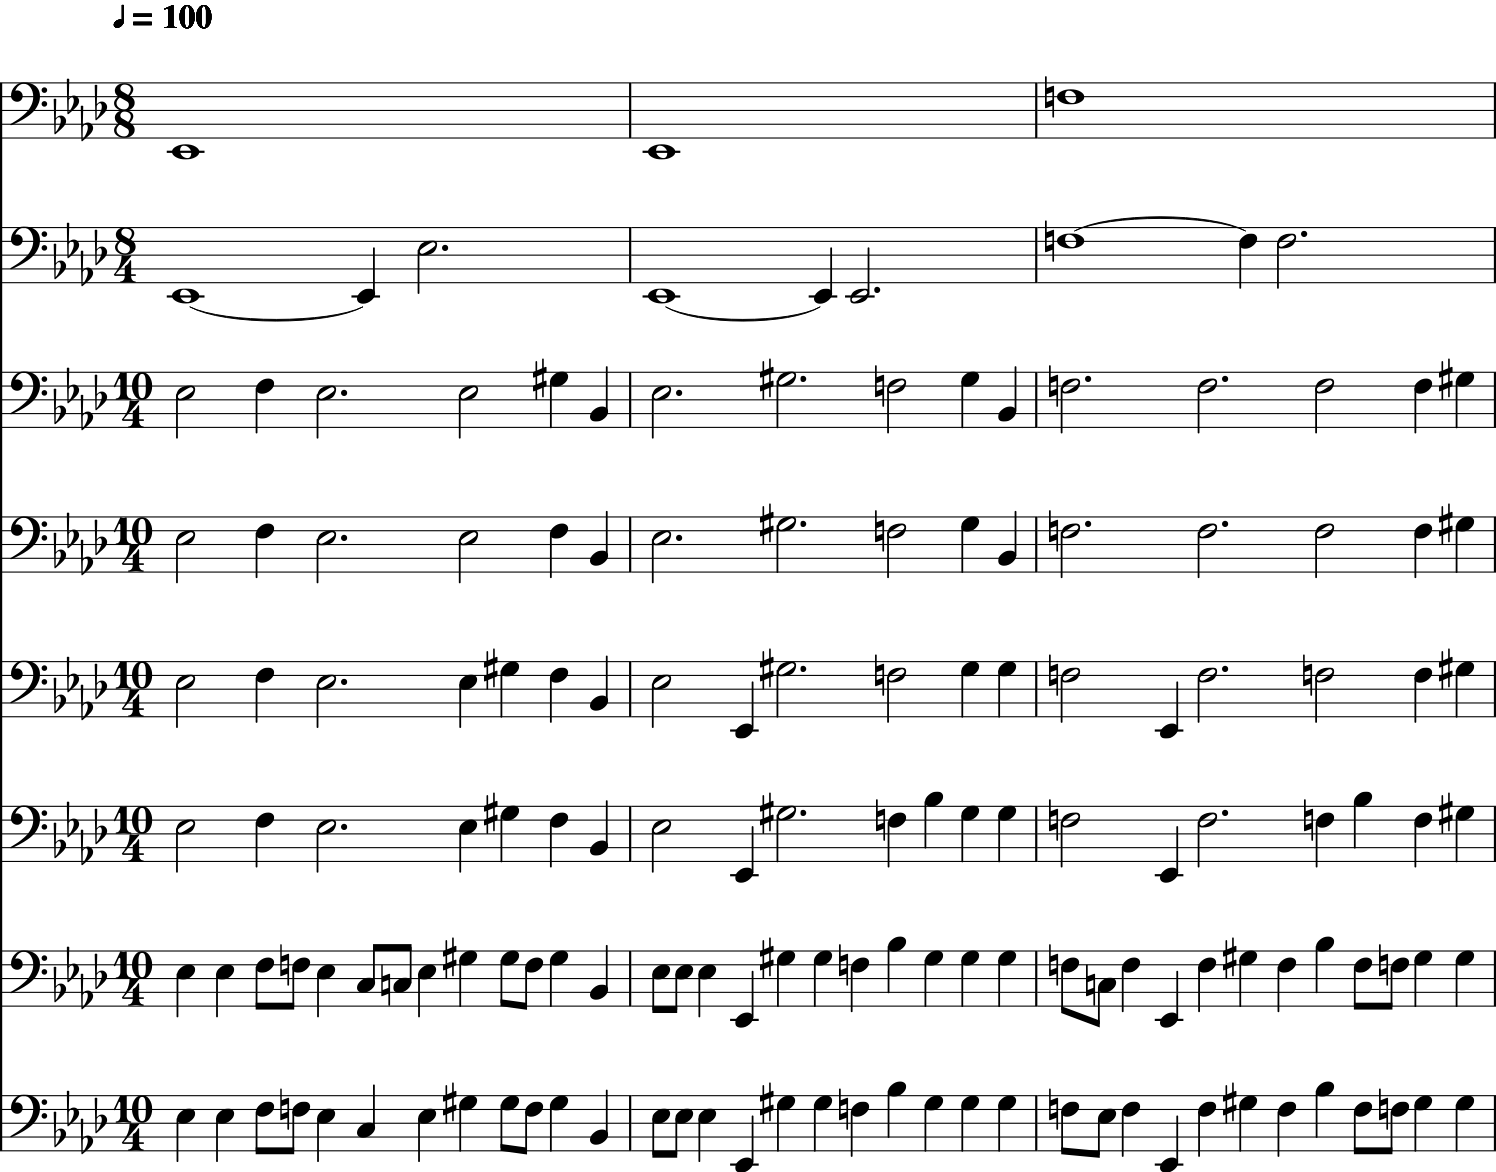

In [57]:
s.show()

In [1]:
model.dynamic_template_list[1]

NameError: name 'model' is not defined

In [52]:

converted_output = convert_note_to_sampling(output, model.dynamic_template_list, beat_sampling_num=model.sampling_rate)
converted_output = convert_onset_to_sustain_token(converted_output)

converted_output

array([[ 1, 51,  3,  0],
       [ 1,  0,  6,  1],
       [ 1,  0,  5,  2],
       [ 1,  0,  6,  3],
       [ 1,  0,  5,  4],
       [ 1,  0,  6,  5],
       [ 1,  0,  4,  6],
       [ 1,  0,  6,  7],
       [ 1,  0,  5,  8],
       [ 1,  0,  6,  9],
       [ 1, 53,  3, 10],
       [ 1,  0,  6, 11],
       [ 1,  0,  5, 12],
       [ 1,  0,  6, 13],
       [ 1, 53,  5, 14],
       [ 1,  0,  6, 15],
       [ 1, 39,  3, 16],
       [ 1,  0,  6, 17],
       [ 1,  0,  5, 18],
       [ 1,  0,  6, 19],
       [ 1,  0,  5, 20],
       [ 1,  0,  6, 21],
       [ 1,  0,  4, 22],
       [ 1,  0,  6, 23],
       [ 1,  0,  5, 24],
       [ 1,  0,  6, 25],
       [ 1, 51,  3, 26],
       [ 1,  0,  6, 27],
       [ 1,  0,  5, 28],
       [ 1,  0,  6, 29],
       [ 1,  0,  5, 30],
       [ 1,  0,  6, 31],
       [ 1, 51,  3, 32],
       [ 1,  0,  6, 33],
       [ 1,  0,  5, 34],
       [ 1,  0,  6, 35],
       [ 1,  0,  5, 36],
       [ 1,  0,  6, 37],
       [ 1,  0,  4, 38],
       [ 1,  0,  6, 39],


In [6]:
model.converter

In [12]:
val_dataset[0][1]

tensor([[ 1,  6,  3],
        [ 1,  9,  4],
        [ 1,  8,  5],
        [ 1,  9,  6],
        [ 1,  8,  7],
        [ 1,  9,  8],
        [ 1,  7,  9],
        [ 1,  9, 10],
        [ 1,  8, 11],
        [ 1,  9, 12],
        [ 1,  6, 13],
        [ 1,  9, 14],
        [ 1,  8, 15],
        [ 1,  9, 16],
        [ 1,  8, 17],
        [ 1,  9, 18],
        [ 1,  6, 19],
        [ 1,  9, 20],
        [ 1,  8, 21],
        [ 1,  9, 22],
        [ 1,  8, 23],
        [ 1,  9, 24],
        [ 1,  7, 25],
        [ 1,  9, 26],
        [ 1,  8, 27],
        [ 1,  9, 28],
        [ 1,  6, 29],
        [ 1,  9, 30],
        [ 1,  8, 31],
        [ 1,  9, 32],
        [ 1,  8, 33],
        [ 1,  9, 34],
        [ 1,  6, 35],
        [ 1,  9, 36],
        [ 1,  8, 37],
        [ 1,  9, 38],
        [ 1,  8, 39],
        [ 1,  9, 40],
        [ 1,  7, 41],
        [ 1,  9, 42],
        [ 1,  8, 43],
        [ 1,  9, 44],
        [ 1,  6, 45],
        [ 1,  9, 46],
        [ 1,  8, 47],
        [ 

In [7]:
from metric import make_dynamic_template, convert_dynamics_to_integer


def make_dec_input(self, part_idx, sampling_rate, measure_len):
  dynamic_template = convert_dynamics_to_integer(make_dynamic_template(beat_sampling_num=sampling_rate)[part_idx])
  num_frames = len(dynamic_template) * measure_len

  output = np.zeros((num_frames, 4), dtype=np.int8)
  output[:, 0] = part_idx
  output[:, 1] = 0 # add dummy note
  output[:, 2] = dynamic_template * measure_len
  output[:, 3] = np.arange(num_frames)

  output = torch.LongTensor([self.tokenizer(frame)  for frame in output] )
  return output[:, [0, 2, 3]]

self = model
make_dec_input(self, 2, 2, 4)

tensor([[ 2,  6,  3],
        [ 2,  9,  4],
        [ 2,  8,  5],
        [ 2,  9,  6],
        [ 2,  8,  7],
        [ 2,  9,  8],
        [ 2,  7,  9],
        [ 2,  9, 10],
        [ 2,  8, 11],
        [ 2,  9, 12],
        [ 2,  8, 13],
        [ 2,  9, 14],
        [ 2,  6, 15],
        [ 2,  9, 16],
        [ 2,  8, 17],
        [ 2,  9, 18],
        [ 2,  7, 19],
        [ 2,  9, 20],
        [ 2,  8, 21],
        [ 2,  9, 22],
        [ 2,  6, 23],
        [ 2,  9, 24],
        [ 2,  8, 25],
        [ 2,  9, 26],
        [ 2,  8, 27],
        [ 2,  9, 28],
        [ 2,  7, 29],
        [ 2,  9, 30],
        [ 2,  8, 31],
        [ 2,  9, 32],
        [ 2,  8, 33],
        [ 2,  9, 34],
        [ 2,  6, 35],
        [ 2,  9, 36],
        [ 2,  8, 37],
        [ 2,  9, 38],
        [ 2,  7, 39],
        [ 2,  9, 40],
        [ 2,  8, 41],
        [ 2,  9, 42],
        [ 2,  6, 43],
        [ 2,  9, 44],
        [ 2,  8, 45],
        [ 2,  9, 46],
        [ 2,  8, 47],
        [ 

In [9]:
from constants import MEAS_LEN_BY_IDX
src, dec_in, tgt = val_dataset[0]
sampling_rate = 2
target_idx = 1

with torch.inference_mode():
  encode_out, enc_last_hidden = self.encoder(src.unsqueeze(0)) 
  src_part_idx = int(src[0][0])

  measure_len = int(src.shape[0] / sampling_rate / MEAS_LEN_BY_IDX[src_part_idx])
  dec_input = make_dec_input(self, target_idx, sampling_rate, measure_len)
  dec_input = self.decoder._get_embedding(dec_input)
  decode_out, last_hidden = self.decoder.rnn(dec_input.unsqueeze(0), enc_last_hidden)
  attention_vectors, attention_weight = self._get_attention_vector(encode_out, decode_out)
  combined_value = torch.cat([decode_out, attention_vectors], dim=-1)
  combined_value = combined_value.squeeze(0)
  logit = self.decoder.proj(combined_value)
  selected_pitch = torch.argmax(logit, dim=-1)

  selected_token = [[target_idx, int(p)] for p in selected_pitch]


  # tgt_dynamic_templates = tokenized_dynamics[part_idx]
  # dec_input = torch.zeros((measure_len*len(tgt_dynamic_templates), 2), dtype=torch.long)
  # dec_input[..., 0] = part_idx
  # dec_input[..., 1] = torch.LongTensor([tgt_dynamic_templates * measure_len])
  # assert src.ndim == 2 # sequence length, feature length


[[1, 44.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 44.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 44.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 53.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 53.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 53.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 53.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 53.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 53.0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0]]

In [34]:
from yeominrak_processing import Tokenizer

class RollConverter(Converter):
  def __init__(self, tokenizer:Tokenizer, sampling_rate=2):
    super().__init__(tokenizer)
    self.sampling_rate = sampling_rate

  def convert_to_note_event(self, frame_list):
    note_list = []
    prev_pitch = 0
    note_duration = 0
    part_idx = frame_list[0][0]
    for frame in frame_list:
      _, pitch = frame
      if pitch == 0:
        note_duration += 1
        continue
      else:
        if prev_pitch != 0:
          note_list.append([part_idx, prev_pitch, note_duration / sampling_rate])
        prev_pitch = pitch
        note_duration = 1
    if prev_pitch != 0:
      note_list.append([part_idx, prev_pitch, note_duration / sampling_rate])
    return note_list
  
  def __call__(self, output): #[pitch, in_onset]
    converted = [self._convert_note(note) for note in output]
    converted = self.convert_to_note_event(converted)
    return converted
  
converter = RollConverter(model.tokenizer)
converter(selected_token)
# [x[2] for x in converter(selected_token)]

[[1, 44.0, 3.0],
 [1, 44.0, 2.0],
 [1, 44.0, 3.0],
 [1, 53.0, 5.0],
 [1, 53.0, 3.0],
 [1, 53.0, 5.0],
 [1, 53.0, 3.0],
 [1, 53.0, 5.0],
 [1, 53.0, 3.0]]

In [51]:
self.tokenizer.key_types

['index', 'pitch', 'dynamic', 'offset']

In [ ]:

def inference(self, src, part_idx):
  with torch.inference_mode():
    encode_out, enc_last_hidden = self.encoder(src.unsqueeze(0)) 
    src_part_idx = int(src[0][0])
    measure_len = src.shape[0]
    
    tgt_dynamic_templates = tokenized_dynamics[part_idx]
    dec_input = torch.zeros((measure_len*len(tgt_dynamic_templates), 2), dtype=torch.long)
    dec_input[..., 0] = part_idx
    dec_input[..., 1] = torch.LongTensor([tgt_dynamic_templates * measure_len])
    assert src.ndim == 2 # sequence length, feature length
          
    # dec_out = self.decoder(dec_input.to('cpu'), enc_last_hidden.to('cpu'))
    dec_input = self.decoder._get_dec_input_embedding(dec_input)
    decode_out, last_hidden = self.decoder.rnn(dec_input.unsqueeze(0), enc_last_hidden)
    attention_vectors, attention_weight = self._get_attention_vector(encode_out, decode_out)
    combined_value = torch.cat([decode_out, attention_vectors], dim=-1)
    combined_value = combined_value.squeeze(0)
    selected_pitch = torch.argmax(combined_value[:, :self.vocab_size[1]], dim=-1)
    # selected_is_onset = (dec_out.data[:, -1] >0.5)
    selected_is_onset = [1 if x > 0.05 else 0 for x in combined_value[:, -1]]        
    selected_token = [[part_idx, int(p),o] for p, o in zip(selected_pitch, selected_is_onset)]
      
    return self.converter(src), self.converter(selected_token)

In [221]:
batch = next(iter(train_loader))

src, dec_in, tgt = batch
dec_in.data.shape, tgt.data.shape

(torch.Size([4944, 3]), torch.Size([4944, 1]))

In [210]:
pad_packed_sequence(dec_in, batch_first=True)[0][0]

tensor([[ 7,  6,  3],
        [ 7,  9,  4],
        [ 7,  8,  5],
        [ 7,  9,  6],
        [ 7,  8,  7],
        [ 7,  9,  8],
        [ 7,  7,  9],
        [ 7,  9, 10],
        [ 7,  8, 11],
        [ 7,  9, 12],
        [ 7,  6, 13],
        [ 7,  9, 14],
        [ 7,  8, 15],
        [ 7,  9, 16],
        [ 7,  7, 17],
        [ 7,  9, 18],
        [ 7,  8, 19],
        [ 7,  9, 20],
        [ 7,  8, 21],
        [ 7,  9, 22],
        [ 7,  6, 23],
        [ 7,  9, 24],
        [ 7,  8, 25],
        [ 7,  9, 26],
        [ 7,  8, 27],
        [ 7,  9, 28],
        [ 7,  7, 29],
        [ 7,  9, 30],
        [ 7,  8, 31],
        [ 7,  9, 32],
        [ 7,  6, 33],
        [ 7,  9, 34],
        [ 7,  8, 35],
        [ 7,  9, 36],
        [ 7,  7, 37],
        [ 7,  9, 38],
        [ 7,  8, 39],
        [ 7,  9, 40],
        [ 7,  8, 41],
        [ 7,  9, 42],
        [ 7,  6, 43],
        [ 7,  9, 44],
        [ 7,  8, 45],
        [ 7,  9, 46],
        [ 7,  8, 47],
        [ 

In [211]:
pad_packed_sequence(src, batch_first=True)[0][0]

tensor([[ 6, 11,  6,  3],
        [ 6,  3,  9,  4],
        [ 6,  3,  8,  5],
        [ 6,  3,  9,  6],
        [ 6,  5,  8,  7],
        [ 6,  3,  9,  8],
        [ 6, 11,  7,  9],
        [ 6,  3,  9, 10],
        [ 6,  3,  8, 11],
        [ 6,  3,  9, 12],
        [ 6, 11,  6, 13],
        [ 6,  3,  9, 14],
        [ 6,  3,  8, 15],
        [ 6,  3,  9, 16],
        [ 6, 11,  7, 17],
        [ 6,  3,  9, 18],
        [ 6, 12,  8, 19],
        [ 6,  3,  9, 20],
        [ 6,  3,  8, 21],
        [ 6,  3,  9, 22],
        [ 6,  9,  6, 23],
        [ 6,  3,  9, 24],
        [ 6,  3,  8, 25],
        [ 6,  3,  9, 26],
        [ 6, 12,  8, 27],
        [ 6,  3,  9, 28],
        [ 6, 11,  7, 29],
        [ 6,  3,  9, 30],
        [ 6,  3,  8, 31],
        [ 6,  3,  9, 32],
        [ 6, 12,  6, 33],
        [ 6,  3,  9, 34],
        [ 6,  3,  8, 35],
        [ 6,  3,  9, 36],
        [ 6, 11,  7, 37],
        [ 6,  3,  9, 38],
        [ 6,  9,  8, 39],
        [ 6,  3,  9, 40],
        [ 6,

In [230]:
import torch.nn as nn
from model_zoo import QkvAttnDecoder, MultiEmbedding

class QkvRollSeq2seq(QkvAttnSeq2seq):
  def __init__(self, vocab, config):
    super().__init__(vocab, config)    
    self.encoder.return_reduced_bidirectional = False
    self.decoder = QkvRollDecoder(self.vocab_size_dict, self.config)

  def forward(self, src, dec_input):
    enc_out, enc_last_hidden = self.encoder(src)
    dec_out = self.decoder(src, dec_input, enc_out, enc_last_hidden)
    return dec_out
  
  def inference(self, src, tokenized_dynamics, part_idx):
    with torch.inference_mode():
      encode_out, enc_last_hidden = self.encoder(src.unsqueeze(0)) 
      src_part_idx = int(src[0][0])
      measure_len = int(src.shape[0]//len(tokenized_dynamics[src_part_idx]))
      
      tgt_dynamic_templates = tokenized_dynamics[part_idx]
      dec_input = torch.zeros((measure_len*len(tgt_dynamic_templates), 2), dtype=torch.long)
      dec_input[..., 0] = part_idx
      dec_input[..., 1] = torch.LongTensor([tgt_dynamic_templates * measure_len])
      assert src.ndim == 2 # sequence length, feature length
            
      # dec_out = self.decoder(dec_input.to('cpu'), enc_last_hidden.to('cpu'))
      dec_input = self.decoder._get_dec_input_embedding(dec_input)
      decode_out, last_hidden = self.decoder.rnn(dec_input.unsqueeze(0), enc_last_hidden)
      attention_vectors, attention_weight = self._get_attention_vector(encode_out, decode_out)
      combined_value = torch.cat([decode_out, attention_vectors], dim=-1)
      combined_value = combined_value.squeeze(0)
      selected_pitch = torch.argmax(combined_value[:, :self.vocab_size[1]], dim=-1)
      # selected_is_onset = (dec_out.data[:, -1] >0.5)
      selected_is_onset = [1 if x > 0.05 else 0 for x in combined_value[:, -1]]        
      selected_token = [[part_idx, int(p),o] for p, o in zip(selected_pitch, selected_is_onset)]
      
    return self.converter(src), self.converter(selected_token)


class QkvRollDecoder(QkvAttnDecoder):
  def __init__(self, vocab_size_dict: dict, param):
    self.param = param
    super().__init__(vocab_size_dict, param)
    self.rnn = nn.GRU(self.emb.total_size, self.hidden_size, num_layers=param.gru.num_layers, batch_first=True, bidirectional=True, dropout=param.gru.dropout)
    self.query = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.key = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.value = nn.Linear(self.hidden_size * 2, self.hidden_size)
    self.dropout = nn.Dropout(param.gru.dropout)

  def _make_embedding_layer(self): # 
    vocab_size_dict = copy.copy(self.vocab_size_dict)
    vocab_size_dict.pop('pitch')
    self.emb = MultiEmbedding(vocab_size_dict, self.param.emb)


  def _apply_softmax(self, logit):
    pitch_output = torch.softmax(logit, dim=-1)
    return pitch_output

  def _make_projection_layer(self):
    # total_vocab_size = sum([x for x in self.vocab_size_dict.values()])
    self.proj = nn.Linear(self.hidden_size * 3, self.vocab_size[1]) # pitch + is_onset
    
  def forward(self, src, dec_input, enc_hidden_state_by_t, enc_out):
    if isinstance(dec_input, PackedSequence):
      emb = self._get_embedding(dec_input.data)
      emb = PackedSequence(emb, dec_input[1], dec_input[2], dec_input[3])
      dec_hidden_state_by_t, dec_out = self.rnn(emb, enc_out)
      mask = pad_packed_sequence(src, batch_first=True)[0][... , 1:2] != 0
      # out = pad_packed_sequence(out, batch_first=True)[0]
      encoder_hidden_states, source_lens = pad_packed_sequence(enc_hidden_state_by_t, batch_first=True)
      decoder_hidden_states, target_lens = pad_packed_sequence(dec_hidden_state_by_t, batch_first=True)
      query = self.query(decoder_hidden_states)
      key = self.key(encoder_hidden_states)
      value = self.value(encoder_hidden_states)
      
      attention_score = torch.bmm(key, query.transpose(1, 2))
      attention_score = attention_score.masked_fill(mask == 0, -float("inf"))
      attention_weight = torch.softmax(attention_score, dim=1)
      attention_vec = torch.bmm(attention_weight.transpose(1, 2), value)
      dec_output = torch.cat([decoder_hidden_states, attention_vec], dim=-1)
      dec_output = self.dropout(dec_output)
      
      logit = self.proj(dec_output)
      prob = self._apply_softmax(logit)
      prob = pack_padded_sequence(prob, target_lens, batch_first=True, enforce_sorted=False)
      
    else:
      raise NotImplementedError
    return prob, attention_weight


class SimpleRoleDecoder(QkvRollDecoder):
  def __init__(self, vocab_size_dict: dict, param):
    self.param = param
    super().__init__(vocab_size_dict, param)
    self.rnn = nn.GRU(self.emb.total_size, self.hidden_size, num_layers=param.gru.num_layers, batch_first=True, bidirectional=True, dropout=param.gru.dropout)


  def _make_projection_layer(self):
    # total_vocab_size = sum([x for x in self.vocab_size_dict.values()])
    self.proj = nn.Linear(self.hidden_size * 2, self.vocab_size[1]) # pitch

  def forward(self, src, dec_input, enc_hidden_state_by_t, enc_out):
    emb = self._get_embedding(dec_input.data)
    emb = PackedSequence(emb, dec_input[1], dec_input[2], dec_input[3])
    dec_hidden_state_by_t, dec_out = self.rnn(emb, enc_out)
    logit = self.proj(dec_hidden_state_by_t.data)
    prob = self._apply_softmax(logit)
    prob = PackedSequence(prob, dec_hidden_state_by_t[1], dec_hidden_state_by_t[2], dec_hidden_state_by_t[3])
    return prob, None
    

model = QkvRollSeq2seq(train_dataset.tokenizer, config.model)
out, _  = model(src, dec_in)
out.data.shape

torch.Size([1008, 18])

In [198]:
out

PackedSequence(data=tensor([[0.0748, 0.0547, 0.0540,  ..., 0.0604, 0.0631, 0.0680],
        [0.0646, 0.0561, 0.0496,  ..., 0.0563, 0.0608, 0.0665],
        [0.0664, 0.0576, 0.0457,  ..., 0.0559, 0.0642, 0.0599],
        ...,
        [0.0541, 0.0621, 0.0435,  ..., 0.0572, 0.0564, 0.0551],
        [0.0542, 0.0575, 0.0433,  ..., 0.0606, 0.0560, 0.0554],
        [0.0612, 0.0538, 0.0529,  ..., 0.0668, 0.0564, 0.0455]],
       grad_fn=<SoftmaxBackward0>), batch_sizes=tensor([64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 52, 52, 52, 52, 52, 52, 52, 52,
        52, 52, 52, 52, 52, 52, 52, 52]), sorted_indices=tensor([55, 28, 29, 30, 58,  0, 33, 35, 36, 56, 38, 39, 40, 27, 42, 43, 44, 45,
        46, 47, 48, 54, 50, 51, 52, 53, 14, 63,  2,  3,  4,  5,  6,  7,  8,  

In [225]:
model = QkvRollSeq2seq(train_dataset.tokenizer, config.model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)
for epoch in range(3):
  for batch in train_loader:
    src, dec_in, tgt = batch
    out, _  = model(src.to(device), dec_in.to(device))
    loss = loss_fn(out.data, tgt.data[:,0])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())

2.985161066055298
2.597226142883301
2.1543571949005127
1.9506030082702637
1.7108746767044067
1.7150934934616089
1.5936986207962036
1.6248937845230103
1.4312227964401245


In [195]:
loss = out.data[torch.arange(len(tgt.data[:,0])), tgt.data[:,0]]
loss.mean().backward()

In [196]:
next(iter(model.decoder.parameters())).grad

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.7630e-05,  3.1327e-04,  3.4326e-05, -4.9329e-05,  1.1120e-04,
          2.1806e-06,  1.4149e-05, -1.3432e-05,  1.2176e-05,  3.0430e-04,
         -1.5223e-04,  2.6507e-04, -1.3898e-05, -1.2992e-04, -3.1400e-05,
         -4.6967e-05, -3.1633e-05, -3.0481e-05,  1.5717e-04, -7.3644e-05,
         -2.1870e-04,  3.7753e-05,  1.2875e-04,  1.0189e-04, -1.9722e-04,
         -7.4871e-05, -1.5535e-07, -1.0264e-04,  1.0242e-04, -2.0213e-04,
         -3.9414e-05,  1.7060e-04],
        [ 5.3453e-05,  2.4536e-04,  7.93

In [133]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nll_loss
save_dir = Path('./debug/')

trainer = Trainer(model=model, optimizer=optimizer, 
                  loss_fn=loss_fn, train_loader=train_loader, 
                  valid_loader=valid_loader, device = device, save_log=False, save_dir=save_dir)


In [232]:
import wandb
class RollTrainer(Trainer):
  def __init__(self, model, optimizer, loss_fn, train_loader, valid_loader, device, save_dir, save_log=True):
    super().__init__(model, optimizer, loss_fn, train_loader, valid_loader, device, save_dir, save_log)

  def get_loss_from_single_batch(self, batch):
    src, tgt, shifted_tgt = batch
    src = src.to(self.device)
    tgt = tgt.to(self.device)
    pred, attn_weight = self.model(src, tgt)
    pitch_loss = self.loss_fn(pred.data, shifted_tgt.data[:,0])
    total_loss = pitch_loss
    
    loss_dict = {'pitch_loss': pitch_loss.item(), 'dur_loss': pitch_loss.item(), 'total_loss': total_loss.item()}
    return total_loss, pred, loss_dict, attn_weight

  def get_valid_loss_from_single_batch(self, batch):
    src, _, shifted_tgt = batch
    loss, pred, loss_dict, attention_weight = self.get_loss_from_single_batch(batch)
    num_tokens = pred.data.shape[0]
    pitch_acc = float(torch.sum(torch.argmax(pred.data, dim=-1) == shifted_tgt.to(self.device).data[:,0])) / num_tokens
    main_acc = pitch_acc
    
    validation_loss = loss.item()

    loss_dict['pitch_acc'] = pitch_acc
    loss_dict['dur_acc'] = pitch_acc
    loss_dict['main_acc'] = main_acc
        
    return main_acc, pitch_acc, pitch_acc, validation_loss, num_tokens, loss_dict


import torch.nn as nn
from model_zoo import QkvAttnDecoder, MultiEmbedding



model = QkvRollSeq2seq(train_dataset.tokenizer, config.model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = RollTrainer(model=model, optimizer=optimizer, 
                  loss_fn=loss_fn, train_loader=train_loader, 
                  valid_loader=valid_loader, device = device, save_log=False, save_dir=save_dir)
trainer.train_by_num_epoch(50)

  0%|          | 0/50 [00:00<?, ?it/s]

[tensor([[[6.4784e-26, 1.4906e-05, 1.7799e-07,  ..., 1.5952e-04,
           1.8063e-42, 2.6328e-03],
          [1.5741e-32, 1.7958e-03, 2.4793e-10,  ..., 4.0715e-03,
           0.0000e+00, 1.3657e-02],
          [1.0406e-38, 2.8385e-01, 5.4932e-13,  ..., 1.1875e-01,
           0.0000e+00, 7.4039e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[2.1725e-20, 1.2836e-03, 6.8845e-10,  ..., 1.5435e-03,
           1.1586e-33, 2.1560e-02],
          [1.1199e-31, 3.0574e-02, 4.0125e-19,  ..., 1.2948e-02,
           0.0000e+00, 5.3036e-03],
          [6.1980e-28, 1.3253e-02, 9.9311e-16,  ..., 1.8373e-02,
           4.7148e-41, 2.3519e-02],
          ...,
          [8.4820e-21, 7.4208e-15, 7.3055e-15,  ..., 6.954

In [80]:
def make_dynamic_template(offset_list=MEAS_LEN_BY_IDX, beat_sampling_num=6):
  whole_dynamic_template = []
  for part_idx in range(8):
      frame = beat_sampling_num
      if part_idx == 0:
          # 세종실록악보 : 2.5/1.5, 1.5/1/1.5
          dynamic_mapping = {0.0: 'strong', 2.5: 'strong', 1.5: 'middle', \
              0.5: 'weak', 1.0: 'weak', 2.0: 'weak', 3.0: 'weak',3.5: 'weak'}
          # frame = frame * 2 #세종실록인 경우는 frame이 두 배!
      
      elif part_idx == 1:
          # 금합자보: 5/3, 3/2/3
          dynamic_mapping = {0.0: 'strong', 5.0: 'strong', 3.0: 'middle',\
              1.0: 'weak', 2.0: 'weak', 4.0: 'weak', 6.0: 'weak', 7.0: 'weak',}
      
      elif part_idx in [2, 3, 4, 5]:
          # 속악원보, 금보신증가령, 한금신보, 어은보: 6/4, 3/3/2/2 
          dynamic_mapping = {0.0: 'strong', 6.0: 'strong', 3.0: 'middle', 8.0: 'middle', \
              1.0: 'weak', 2.0: 'weak', 4.0: 'weak', 5.0: 'weak', 7.0: 'weak', 9.0: 'weak'}
      
      elif part_idx in [6, 7]:
          # 삼죽금보, 현행: 5/5, 3/2/2/3
          dynamic_mapping = {0.0: 'strong', 5.0: 'strong', 3.0: 'middle', 7.0: 'middle',\
              1.0: 'weak', 2.0: 'weak', 4.0: 'weak', 6.0: 'weak', 8.0: 'weak', 9.0: 'weak'}
      whole_measure_len = int(frame * offset_list[part_idx])
      dynamic_list = []
      for i in range(whole_measure_len):
          dynamic = dynamic_mapping.get(float(i) / frame, 'none')
          dynamic_list.append(dynamic)
      whole_dynamic_template.append(dynamic_list)
  return whole_dynamic_template

def convert_dynamics_to_integer(dynamics):
  dynamic_mapping = {'strong': 3, 'middle':4 , 'weak':5, 'none': 6}
  return [dynamic_mapping[d] for d in dynamics]


from constants import MEAS_LEN_BY_IDX
dynamic_notated_roll_list = make_dynamic_template(MEAS_LEN_BY_IDX, beat_sampling_num=2)
dynamic_notated_roll_list = [convert_dynamics_to_integer(d) for d in dynamic_notated_roll_list]

In [44]:
len(dynamic_notated_roll_list[5])

20

In [115]:
def convert_note_to_sampling(measure, dynamic_templates, beat_sampling_num = 6):
  if len(measure) == 0:
    return [['empty'] for _ in range(10 * beat_sampling_num)]  # 어차피, 4,5만 비어있으니까 괜찮을 것 같음! 
    
  measure_duration = sum([note[2] for note in measure])
  new_measure = np.zeros((int(measure_duration * beat_sampling_num), 5), dtype=np.int8) # part_idx, pitch, onset, dynamic, position
  new_measure[:, 0] = measure[0][0] # part_idx
  new_measure[:, 3] = dynamic_templates[measure[0][0]] * (len(new_measure)//len(dynamic_templates[measure[0][0]]))
  new_measure[:, 4] = np.arange(len(new_measure))
  current_beat = 0


  for note in measure:
    onset_frame = int(beat_sampling_num * current_beat)
    offset_frame = int(beat_sampling_num * (current_beat + note[2]))
    new_measure[onset_frame:offset_frame, 1] = note[1] # pitch
    new_measure[onset_frame, 2] = 1
    current_beat += note[2]

  return convert_onset_to_sustain_token(new_measure)


def convert_onset_to_sustain_token(roll_array: np.ndarray):
  roll_array[roll_array[:,2]!=1, 1] = 0
  return roll_array[:, [0,1,3,4]]


measure = train_dataset.measure_features[7][0]
roll_out = convert_note_to_sampling(measure, dynamic_notated_roll_list, beat_sampling_num = 6)
print(roll_out)
# roll_out = convert_onset_to_sustain_token(roll_out)
# roll_out

[[ 7 51  3  0]
 [ 7  0  6  1]
 [ 7  0  5  2]
 [ 7  0  6  3]
 [ 7  0  5  4]
 [ 7  0  6  5]
 [ 7 51  4  6]
 [ 7  0  6  7]
 [ 7  0  5  8]
 [ 7  0  6  9]
 [ 7  0  3 10]
 [ 7  0  6 11]
 [ 7  0  5 12]
 [ 7  0  6 13]
 [ 7  0  4 14]
 [ 7  0  6 15]
 [ 7  0  5 16]
 [ 7  0  6 17]
 [ 7 51  5 18]
 [ 7  0  6 19]
 [ 7  0  3 20]
 [ 7  0  6 21]
 [ 7  0  5 22]
 [ 7  0  6 23]
 [ 7 46  5 24]
 [ 7  0  6 25]
 [ 7  0  4 26]
 [ 7 51  6 27]
 [ 7  0  5 28]
 [ 7  0  6 29]
 [ 7 51  3 30]
 [ 7  0  6 31]
 [ 7  0  5 32]
 [ 7  0  6 33]
 [ 7  0  4 34]
 [ 7  0  6 35]
 [ 7 51  5 36]
 [ 7  0  6 37]
 [ 7  0  5 38]
 [ 7  0  6 39]
 [ 7  0  3 40]
 [ 7  0  6 41]
 [ 7 48  5 42]
 [ 7  0  6 43]
 [ 7  0  5 44]
 [ 7  0  6 45]
 [ 7  0  4 46]
 [ 7  0  6 47]
 [ 7 46  5 48]
 [ 7  0  6 49]
 [ 7  0  3 50]
 [ 7  0  6 51]
 [ 7  0  5 52]
 [ 7  0  6 53]
 [ 7 53  4 54]
 [ 7  0  6 55]
 [ 7  0  5 56]
 [ 7  0  6 57]
 [ 7  0  5 58]
 [ 7  0  6 59]]


In [116]:
from yeominrak_processing import Tokenizer

class SamplingTokenizer(Tokenizer):
  def __init__(self, parts, feature_types=['part_idx', 'pitch',  'offset', 'dynamic']):
    super().__init__(parts, feature_types)
    

  def __call__(self, x):

    return



In [144]:
class SamplingScore(AlignedScore):
  def __init__(self, xml_path='0_edited.musicxml', 
               valid_measure_num=[i for i in range(93, 104)], 
               slice_measure_num=2, is_valid=False, 
               use_pitch_modification=False, 
               pitch_modification_ratio=0, 
               min_meas=3, 
               max_meas=6, 
               feature_types=[],
               sampling_rate=2) -> None:
    super().__init__(xml_path, valid_measure_num, slice_measure_num, is_valid, use_pitch_modification, pitch_modification_ratio, min_meas, max_meas, feature_types)
    self.sampling_rate = sampling_rate
    self.dynamic_template_list = make_dynamic_template(beat_sampling_num=self.sampling_rate)
    self.dynamic_template_list = [convert_dynamics_to_integer(d) for d in self.dynamic_template_list]
    self.tokenizer = SamplingTokenizer(self.parts)

  def get_processed_feature(self, front_part_idx, back_part_idx, idx):
    if self.is_valid:
        measure_list = idx
    else:    
        measure_list = self.slice_info[idx]
    original_source_list = [item for idx in measure_list for item in self.measure_features[front_part_idx][idx]]
    original_target_list = [item for idx in measure_list for item in self.measure_features[back_part_idx][idx]]


    source_roll = convert_note_to_sampling(original_source_list, self.dynamic_template_list, beat_sampling_num=self.sampling_rate)
    target_roll = convert_note_to_sampling(original_target_list, self.dynamic_template_list, beat_sampling_num=self.sampling_rate)

    enc_in = [self.tokenizer(item) for item in source_roll]
    dec_in = [self.tokenizer(item) for item in target_roll]

    enc_in = torch.tensor(enc_in, dtype=torch.long)
    dec_in = torch.tensor(dec_in, dtype=torch.long)

    target = dec_in[:, 1:2]
    dec_in = dec_in[:, [0, 2, 3]]

    return enc_in, dec_in, target

  def __getitem__(self, idx):
    if self.is_valid:
      front_part_idx, back_part_idx, measure_number = self.valid_index[idx]
    else:    
      sample_success = False
      while not sample_success:
        front_part_idx = random.choice(range(len(self.parts)-1))
        # back_part_idx should be bigger than front_part_idx
        back_part_idx = random.randint(front_part_idx + 1, min(len(self.parts) - 1, front_part_idx + 2))
        src, tgt, shifted_tgt = self.get_processed_feature(front_part_idx, back_part_idx, idx)          
        if len(src) > 2 and len(tgt) > 1:
          sample_success = True
    return src, tgt, shifted_tgt
  
roll_dataset = SamplingScore(is_valid= False, 
                              xml_path='0_edited.musicxml',
                              use_pitch_modification = config.data.use_pitch_modification, 
                              pitch_modification_ratio=config.data.modification_ratio,
                              min_meas=config.data.min_meas, 
                              max_meas=config.data.max_meas,
                              feature_types=config.model.features
                              )

In [145]:
roll_dataset[0]

(tensor([[ 5, 11,  6,  3],
         [ 5,  3,  9,  4],
         [ 5, 11,  8,  5],
         [ 5,  3,  9,  6],
         [ 5,  3,  8,  7],
         [ 5,  3,  9,  8],
         [ 5, 11,  7,  9],
         [ 5,  3,  9, 10],
         [ 5,  3,  8, 11],
         [ 5,  3,  9, 12],
         [ 5,  9,  8, 13],
         [ 5,  3,  9, 14],
         [ 5, 11,  6, 15],
         [ 5,  3,  9, 16],
         [ 5, 11,  8, 17],
         [ 5,  3,  9, 18],
         [ 5, 11,  7, 19],
         [ 5,  9,  9, 20],
         [ 5, 12,  8, 21],
         [ 5,  3,  9, 22],
         [ 5, 11,  6, 23],
         [ 5,  3,  9, 24],
         [ 5, 11,  8, 25],
         [ 5,  3,  9, 26],
         [ 5, 11,  8, 27],
         [ 5,  3,  9, 28],
         [ 5,  9,  7, 29],
         [ 5,  3,  9, 30],
         [ 5, 11,  8, 31],
         [ 5,  3,  9, 32],
         [ 5, 12,  8, 33],
         [ 5,  3,  9, 34],
         [ 5, 14,  6, 35],
         [ 5,  3,  9, 36],
         [ 5, 14,  8, 37],
         [ 5,  3,  9, 38],
         [ 5, 14,  7, 39],
 

In [142]:
from yeominrak_processing import Tokenizer

class SamplingTokenizer(Tokenizer):
  def __init__(self, parts, feature_types=['index', 'pitch', 'dynamic',  'offset']):
    num_parts = len(parts)
    self.key_types = feature_types
    vocab_list = defaultdict(list)
    vocab_list['index'] = [i for i in range(num_parts)]
    vocab_list['pitch'] = ['pad', 'start', 'end', 0] + sorted(list(set([note.pitch for i in range(num_parts) for note in parts[i].tie_cleaned_notes])))
    if 'dynamic' in feature_types:
        vocab_list['dynamic'] = ['pad', 'start', 'end'] + list(range(7))
    if 'offset' in feature_types:
        vocab_list['offset'] = ['pad', 'start', 'end'] + list(range(100))

    self.measure_duration = [parts[i].measure_duration for i in range(num_parts)]
    self.vocab = vocab_list
    self.vocab_size_dict = {key: len(value) for key, value in self.vocab.items()}
    self.tok2idx = {key: {k:i for i, k in enumerate(value)} for key, value in self.vocab.items() }
    self.key2idx = {key: i for i, key in enumerate(self.key_types)}
    # self.key_types = ['index', 'pitch', 'duration', 'offset', 'dynamic', 'measure_change']

    self.note2token = {}




enc_in, dec_out, dec_in = roll_dataset[1]
tokenizer = SamplingTokenizer(roll_dataset.parts)
# tokenizer(enc_in)
# tokenizer.vocab
[tokenizer(frame) for frame in enc_in]

[[4, 11, 6, 3],
 [4, 3, 9, 4],
 [4, 11, 8, 5],
 [4, 3, 9, 6],
 [4, 9, 8, 7],
 [4, 3, 9, 8],
 [4, 11, 7, 9],
 [4, 3, 9, 10],
 [4, 3, 8, 11],
 [4, 3, 9, 12],
 [4, 3, 8, 13],
 [4, 3, 9, 14],
 [4, 14, 6, 15],
 [4, 3, 9, 16],
 [4, 14, 8, 17],
 [4, 3, 9, 18],
 [4, 14, 7, 19],
 [4, 12, 9, 20],
 [4, 11, 8, 21],
 [4, 3, 9, 22],
 [4, 9, 6, 23],
 [4, 3, 9, 24],
 [4, 9, 8, 25],
 [4, 3, 9, 26],
 [4, 3, 8, 27],
 [4, 3, 9, 28],
 [4, 8, 7, 29],
 [4, 3, 9, 30],
 [4, 3, 8, 31],
 [4, 3, 9, 32],
 [4, 8, 8, 33],
 [4, 3, 9, 34],
 [4, 9, 6, 35],
 [4, 3, 9, 36],
 [4, 12, 8, 37],
 [4, 3, 9, 38],
 [4, 11, 7, 39],
 [4, 3, 9, 40],
 [4, 9, 8, 41],
 [4, 3, 9, 42],
 [4, 8, 6, 43],
 [4, 3, 9, 44],
 [4, 8, 8, 45],
 [4, 3, 9, 46],
 [4, 3, 8, 47],
 [4, 3, 9, 48],
 [4, 7, 7, 49],
 [4, 3, 9, 50],
 [4, 8, 8, 51],
 [4, 3, 9, 52],
 [4, 8, 8, 53],
 [4, 3, 9, 54],
 [4, 9, 6, 55],
 [4, 3, 9, 56],
 [4, 11, 8, 57],
 [4, 3, 9, 58],
 [4, 8, 7, 59],
 [4, 3, 9, 60],
 [4, 7, 8, 61],
 [4, 3, 9, 62],
 [4, 6, 6, 63],
 [4, 3, 9, 64],
 [4,

In [139]:
enc_in

array([[ 4, 51,  3,  0],
       [ 4,  0,  6,  1],
       [ 4, 51,  5,  2],
       [ 4,  0,  6,  3],
       [ 4, 48,  5,  4],
       [ 4,  0,  6,  5],
       [ 4, 51,  4,  6],
       [ 4,  0,  6,  7],
       [ 4,  0,  5,  8],
       [ 4,  0,  6,  9],
       [ 4,  0,  5, 10],
       [ 4,  0,  6, 11],
       [ 4, 56,  3, 12],
       [ 4,  0,  6, 13],
       [ 4, 56,  5, 14],
       [ 4,  0,  6, 15],
       [ 4, 56,  4, 16],
       [ 4, 53,  6, 17],
       [ 4, 51,  5, 18],
       [ 4,  0,  6, 19],
       [ 4, 48,  3, 20],
       [ 4,  0,  6, 21],
       [ 4, 48,  5, 22],
       [ 4,  0,  6, 23],
       [ 4,  0,  5, 24],
       [ 4,  0,  6, 25],
       [ 4, 46,  4, 26],
       [ 4,  0,  6, 27],
       [ 4,  0,  5, 28],
       [ 4,  0,  6, 29],
       [ 4, 46,  5, 30],
       [ 4,  0,  6, 31],
       [ 4, 48,  3, 32],
       [ 4,  0,  6, 33],
       [ 4, 53,  5, 34],
       [ 4,  0,  6, 35],
       [ 4, 51,  4, 36],
       [ 4,  0,  6, 37],
       [ 4, 48,  5, 38],
       [ 4,  0,  6, 39],


In [65]:
dynamic_notated_roll_list

[['strong',
  'weak',
  'weak',
  'middle',
  'weak',
  'strong',
  'weak',
  'weak',
  'none',
  'none',
  'none',
  'none',
  'none',
  'none',
  'none',
  'none'],
 ['strong',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none',
  'strong',
  'none',
  'weak',
  'none',
  'weak',
  'none'],
 ['strong',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'strong',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none'],
 ['strong',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'strong',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none'],
 ['strong',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none',
  'weak',
  'none',
  'strong',
  'none',
  'weak',
  'none',
  'middle',
  'none',
  'weak',
  'none'],
 ['strong',
  'none',
  'weak',
  'none

In [57]:
train_dataset.measure_features[7][6]

[[7, 41.0, 1.0, 0.0, 'strong', 7],
 [7, 46.0, 0.5, 1.0, 'weak', 7],
 [7, 41.0, 0.5, 1.5, 'weak', 7],
 [7, 39.0, 1.0, 2.0, 'weak', 7],
 [7, 44.0, 1.0, 3.0, 'middle', 7],
 [7, 44.0, 1.0, 4.0, 'weak', 7],
 [7, 41.0, 1.0, 5.0, 'strong', 7],
 [7, 44.0, 1.0, 6.0, 'weak', 7],
 [7, 46.0, Fraction(1, 3), 7.0, 'middle', 7],
 [7, 44.0, Fraction(1, 3), 7.333, 'weak', 7],
 [7, 41.0, Fraction(1, 3), 7.666, 'weak', 7],
 [7, 39.0, 1.0, 8.0, 'weak', 7],
 [7, 39.0, 1.0, 9.0, 'weak', 7]]

In [9]:
trainer.train_by_num_epoch(50)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Model Saved! Accuracy: 0.33881725211204977
Best Model Saved! Accuracy: 0.3583815028901734
Best Model Saved! Accuracy: 0.38972876834148507
Best Model Saved! Accuracy: 0.4032903512672299
Best Model Saved! Accuracy: 0.43775011116051576
Best Model Saved! Accuracy: 0.45175633614939975
Best Model Saved! Accuracy: 0.45686971987550024
Best Model Saved! Accuracy: 0.47598932859048465
Best Model Saved! Accuracy: 0.5260115606936416
Best Model Saved! Accuracy: 0.5689195197865717
Best Model Saved! Accuracy: 0.5740329035126723
Best Model Saved! Accuracy: 0.5947087594486439
Best Model Saved! Accuracy: 0.6051578479324144
Best Model Saved! Accuracy: 0.6102712316585148
Best Model Saved! Accuracy: 0.61827478879502
Best Model Saved! Accuracy: 0.6189417518897288
Best Model Saved! Accuracy: 0.6267229879946643
Best Model Saved! Accuracy: 0.6336149399733215
Best Model Saved! Accuracy: 0.6451756336149399
Best Model Saved! Accuracy: 0.6491774121831926
Best Model Saved! Accuracy: 0.6705202312138728
Best Mode

[tensor([[[2.2739e-04, 8.2955e-06, 1.9129e-04,  ..., 4.0061e-02,
           4.0061e-02, 4.0061e-02],
          [9.0461e-01, 8.8631e-01, 1.6618e-02,  ..., 4.3262e-02,
           4.3262e-02, 4.3262e-02],
          [9.1615e-02, 4.8478e-02, 7.1649e-01,  ..., 4.7460e-02,
           4.7460e-02, 4.7460e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[7.2025e-04, 5.5181e-04, 3.1484e-06,  ..., 2.6768e-02,
           2.6768e-02, 2.6768e-02],
          [6.6391e-01, 4.6247e-01, 2.8915e-04,  ..., 2.8351e-02,
           2.8351e-02, 2.8351e-02],
          [7.1863e-02, 1.0760e-01, 9.0069e-01,  ..., 2.7926e-02,
           2.7926e-02, 2.7926e-02],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.000

In [10]:
self = trainer
model.cpu()

sample = self.valid_loader.dataset[0][0]
input_part_idx = sample[0][0]
# if input_part_idx < 2: continue
if self.model.is_condition_shifted:
  src, output, attn_map = self.model.shifted_inference(sample, input_part_idx+1)

In [13]:
sample

tensor([[ 0,  1,  1,  1,  1,  1],
        [ 0,  6, 14,  3,  3,  3],
        [ 0,  5, 12, 19,  3,  3],
        [ 0,  4,  3,  3,  3,  4],
        [ 0,  4,  3,  3,  3,  5],
        [ 0, 11,  3,  3,  3,  6],
        [ 0, 11,  3,  3,  3,  7],
        [ 0,  8,  3,  3,  3,  8],
        [ 0,  2,  2,  2,  2,  2]])

In [17]:
part_idx = 1
self = model
prev_generation = None
src = sample

encode_out, encode_last_hidden = self.encoder(src.unsqueeze(0)) # 

# Setup for 0th step
# start_token = torch.LongTensor([[part_idx, 1, 1, 3, 3, 4]]) # start token idx is 1
start_token = self.get_start_token(part_idx)
assert src.ndim == 2 # sequence length, feature length
#-------------
not_triplet_vocab_list = [ i for i, dur in enumerate(self.tokenizer.vocab['duration'][3:], 3) if (dur%0.5) != 0.0]
#-------------
measure_duration = self.tokenizer.measure_duration[part_idx]
current_measure_idx = 0
measure_changed = 1

last_hidden = encode_last_hidden
if last_hidden.shape[-1] != self.decoder.gru_size:
  last_hidden = self.decoder.reduce_enc(last_hidden)

final_tokens = []
if prev_generation is not None:
  emb = self.decoder._get_embedding(prev_generation)
  decode_out, last_hidden = self.decoder.rnn(emb.unsqueeze(0), last_hidden)
  start_token = torch.cat([prev_generation[-1:, :3],  torch.LongTensor([[3, 3, 4]])], dim=-1)
  final_tokens.append(start_token)
selected_token = start_token
current_beat = 0.0

total_attention_weights = []
# while True:
for i in range(300):
  emb = self.decoder._get_embedding(selected_token)
  decode_out, last_hidden = self.decoder.rnn(emb.unsqueeze(0), last_hidden)
  attention_vectors, attention_weight = self._get_attention_vector(encode_out, decode_out)
  combined_value = torch.cat([decode_out, attention_vectors], dim=-1)
  selected_token = self.decoder.sampling_process(combined_value, not_triplet_vocab_list)
  
  if selected_token[0, 0]==self.tokenizer.tok2idx['pitch']['end'] or selected_token[0, 1]==self.tokenizer.tok2idx['duration']['end']:
    break
  
  # update beat position and beat strength
  current_dur = self.tokenizer.vocab['duration'][selected_token[0, 1]]
  if current_dur in ('start', 'pad'):
    current_dur = 0.0
  current_beat += current_dur
  if current_beat >= measure_duration:
    current_measure_idx += 1 #마디 수 늘려주기
    measure_changed = 1
    current_beat = current_beat - measure_duration
  else:
    measure_changed = 0
  
  condition_tokens = []
  if 'offset' in self.tokenizer.tok2idx:
    measure_offset_idx = self.tokenizer.tok2idx['offset'][current_beat]
    condition_tokens.append(measure_offset_idx)
  if 'dynamic' in self.tokenizer.tok2idx:
    dynamic = get_dynamic(current_beat, part_idx)
    dynamic_idx = self.tokenizer.tok2idx['dynamic'][dynamic]
    condition_tokens.append(dynamic_idx)
  if 'measure_idx' in self.tokenizer.tok2idx:
    measure_idx = self.tokenizer.tok2idx['measure_idx'][current_measure_idx]
    condition_tokens.append(measure_idx)
  if 'measure_change' in self.tokenizer.tok2idx:
    measure_idx = self.tokenizer.tok2idx['measure_change'][measure_changed]
    condition_tokens.append(measure_idx)
  
  # make new token for next rnn timestep
  selected_token = torch.cat([torch.LongTensor([[part_idx]]), selected_token, torch.LongTensor([condition_tokens])], dim=1)
  
  final_tokens.append(selected_token)
  total_attention_weights.append(attention_weight[0,:,0])
if len(total_attention_weights) == 0:
  attention_map = None
else:
  attention_map = torch.stack(total_attention_weights, dim=1)
cat_out = torch.cat(final_tokens, dim=0)
newly_generated = cat_out.clone()
if prev_generation is not None:
  cat_out = torch.cat([prev_generation[1:], cat_out], dim=0)


tensor([[ 1,  6, 10,  7,  5,  3]])
tensor([[ 1,  5,  7, 11,  4,  3]])
tensor([[ 1,  6, 10, 19,  3,  3]])
tensor([[ 1,  5,  7, 22,  5,  3]])
tensor([[ 1,  5,  7, 25,  5,  3]])
tensor([[1, 5, 7, 3, 3, 4]])
tensor([[ 1,  6, 10,  7,  5,  4]])
tensor([[ 1,  5,  7, 11,  4,  4]])
tensor([[ 1,  6, 10, 19,  3,  4]])
tensor([[ 1,  5,  7, 22,  5,  4]])
tensor([[ 1,  5,  7, 25,  5,  4]])
tensor([[1, 5, 7, 3, 3, 5]])
tensor([[ 1, 11, 10,  7,  5,  5]])
tensor([[ 1,  4,  7, 11,  4,  5]])
tensor([[ 1, 11, 10, 19,  3,  5]])
tensor([[ 1, 11,  7, 22,  5,  5]])
tensor([[ 1, 10,  7, 25,  5,  5]])
tensor([[ 1, 11,  7,  3,  3,  6]])
tensor([[ 1, 10, 14, 19,  3,  6]])
tensor([[ 1, 10, 12,  3,  3,  7]])
tensor([[ 1, 11, 10,  7,  5,  7]])
tensor([[ 1, 13,  7, 11,  4,  7]])
tensor([[ 1, 11, 10, 19,  3,  7]])
tensor([[ 1, 13,  7, 22,  5,  7]])
tensor([[ 1, 11,  7, 25,  5,  7]])
tensor([[ 1, 10,  7,  3,  3,  8]])
tensor([[ 1,  8, 14, 19,  3,  8]])
tensor([[ 1,  8, 12,  3,  3,  9]])


In [ ]:
convert
